# Naive Bayes:

Classifying with supervised learning whether diabetic patients are readmitted, and if they are, if it's before or after 30 days.

Using the dataset from here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [1]:
from imblearn.over_sampling import SMOTE  # SMOTE oversampling
from imblearn.under_sampling import RandomUnderSampler  # Undersampling
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

%pylab inline

%config InlineBackend.figure_format = 'svg'
sns.set_style("white")

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and 

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("y_train_liv.pkl", 'rb') as picklefile:
    y_train_liv = pickle.load(picklefile)

with open("y_test_liv.pkl", 'rb') as picklefile:
    y_test_liv = pickle.load(picklefile)

with open("x_train_liv.pkl", 'rb') as picklefile:
    x_train_liv = pickle.load(picklefile)

with open("x_test_liv.pkl", 'rb') as picklefile:
    x_test_liv = pickle.load(picklefile)

In [3]:
x_train = x_train_liv
y_train = y_train_liv
x_test = x_test_liv
y_test = y_test_liv

In [4]:
def makematrix(y_test, y_pred):
    score = accuracy_score(y_test, y_pred)

    confm = confusion_matrix(y_test, y_pred, labels=list(y_test.unique()))
    confm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    sns.heatmap(confm, annot=True, fmt=".3f",
                linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size=15)

In [5]:
def pr_curve(y_test, model):
    y_test_num = y_test.copy()
    y_test_num = y_test_num.replace('NO', 0)
    y_test_num = y_test_num.replace('<30', 1)

    y_score = model.predict_proba(x_test)[:, 1]
    p, r, t = precision_recall_curve(y_test_num, y_score)

    # adding last threshold of '1' to threshold list
    t = np.vstack([t.reshape([-1, 1]), 1])

    plt.plot(t, p, label='precision')
    plt.plot(t, r, label='recall')
    plt.title('Precision Recall Curve')
    plt.legend()
    # yellow = recall
    # blue = precision

## Reducing the classes to binary classes ('>30' is now also 'NO'):

In [6]:
y_test = y_test.str.replace('>30', 'NO')
y_train = y_train.str.replace('>30', 'NO')

In [7]:
y_test.value_counts()

NO     22190
<30     2839
Name: readmitted, dtype: int64

## Gaussian Naive Bayes:

In [8]:
NBmodel = naive_bayes.GaussianNB()
NBmodel.fit(x_train, y_train)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.12      0.97      0.21      2839
          NO       0.94      0.06      0.12     22190

    accuracy                           0.17     25029
   macro avg       0.53      0.52      0.16     25029
weighted avg       0.85      0.17      0.13     25029



In [9]:
# makematrix(y_test, y_pred)

## Gaussian NB basically just predicted all <30, so recall for that class was great, but everything else was awful

## Bernoulli Naive Bayes:

In [10]:
NBmodel = naive_bayes.BernoulliNB()
NBmodel.fit(x_train, y_train)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.30      0.02      0.05      2839
          NO       0.89      0.99      0.94     22190

    accuracy                           0.88     25029
   macro avg       0.60      0.51      0.49     25029
weighted avg       0.82      0.88      0.84     25029



In [11]:
# makematrix(y_test, y_pred)

## I suppose this makes sense, because most of my data is categorical. I was really hoping for better performance from Gaussian, though.

## Multinomial Naive Bayes:

In [12]:
NBmodel = naive_bayes.MultinomialNB()
NBmodel.fit(x_train, y_train)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.27      0.14      0.19      2839
          NO       0.90      0.95      0.92     22190

    accuracy                           0.86     25029
   macro avg       0.58      0.55      0.55     25029
weighted avg       0.83      0.86      0.84     25029



In [13]:
# makematrix(y_test, y_pred)

## SMOTE:

In [14]:
sm = SMOTE(random_state=42)
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Multinomial + SMOTE:

In [15]:
NBmodel = naive_bayes.MultinomialNB()
NBmodel.fit(x_train_smote, y_train_smote)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.19      0.56      0.28      2839
          NO       0.92      0.69      0.79     22190

    accuracy                           0.67     25029
   macro avg       0.56      0.62      0.53     25029
weighted avg       0.84      0.67      0.73     25029



In [16]:
# makematrix(y_test, y_pred)

## Gaussian + SMOTE:

In [17]:
NBmodel = naive_bayes.GaussianNB()
NBmodel.fit(x_train_smote, y_train_smote)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.12      0.94      0.21      2839
          NO       0.93      0.10      0.17     22190

    accuracy                           0.19     25029
   macro avg       0.52      0.52      0.19     25029
weighted avg       0.83      0.19      0.18     25029



In [18]:
# makematrix(y_test, y_pred)

## Bernoulli + SMOTE:

In [19]:
NBmodel = naive_bayes.BernoulliNB()
NBmodel.fit(x_train_smote, y_train_smote)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.20      0.13      0.16      2839
          NO       0.89      0.93      0.91     22190

    accuracy                           0.84     25029
   macro avg       0.55      0.53      0.53     25029
weighted avg       0.81      0.84      0.83     25029



In [20]:
# makematrix(y_test, y_pred)

## SMOTE did worse across the board.

## Gaussian NB with SMOTE also basically just predicted all <30, so recall for that class was great, but everything else was awful

## Undersampling:

In [21]:
rus = RandomUnderSampler(random_state=0)
x_train_undersampled, y_train_undersampled = rus.fit_sample(x_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# sns.countplot(y_train_undersampled);

## Multinomial + Undersampling:

In [23]:
NBmodel = naive_bayes.MultinomialNB()
NBmodel.fit(x_train_undersampled, y_train_undersampled)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.19      0.52      0.28      2839
          NO       0.92      0.71      0.80     22190

    accuracy                           0.69     25029
   macro avg       0.55      0.62      0.54     25029
weighted avg       0.84      0.69      0.74     25029



In [24]:
# makematrix(y_test, y_pred)

## Gaussian + Undersampling:

In [25]:
NBmodel = naive_bayes.GaussianNB()
NBmodel.fit(x_train_undersampled, y_train_undersampled)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.12      0.90      0.21      2839
          NO       0.93      0.16      0.28     22190

    accuracy                           0.25     25029
   macro avg       0.52      0.53      0.24     25029
weighted avg       0.84      0.25      0.27     25029



In [26]:
# makematrix(y_test, y_pred)

## Bernoulli + Undersampling:

In [27]:
NBmodel = naive_bayes.BernoulliNB()
NBmodel.fit(x_train_undersampled, y_train_undersampled)
y_pred = NBmodel.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         <30       0.17      0.63      0.27      2839
          NO       0.93      0.61      0.74     22190

    accuracy                           0.61     25029
   macro avg       0.55      0.62      0.50     25029
weighted avg       0.84      0.61      0.68     25029



In [28]:
# makematrix(y_test, y_pred)

## Presumably, undersampling and oversampling hurt performance because part of the naive bayes calculation is the probability of each class occurring

## PR Curve for best model:

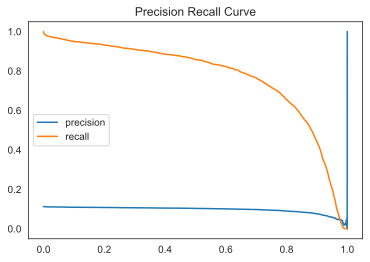

In [29]:
NBmodel = naive_bayes.MultinomialNB()
NBmodel.fit(x_train, y_train)
pr_curve(y_test, model=NBmodel)